<a href="https://colab.research.google.com/github/AndreYang333/ExplainableAI/blob/main/new_assignment7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 7
## Minjie Yang(my189)
 Link to reference code:https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/explainable-ml-example-notebooks/testing_concept_activation_vectors.ipynb

 Link to github:https://github.com/AndreYang333/ExplainableAI.git

# Code Part

In [36]:
# We are going to clone the tcav repo in GitHub:
!git clone https://github.com/tensorflow/tcav.git tcav
%cd tcav
!ls

# Next, we will create the datasets
%cd /content/tcav/tcav/tcav_examples/image_models/imagenet
%run download_and_make_datasets.py --source_dir=Minjie --number_of_images_per_folder=10 --number_of_random_folders=15

%cd /content/tcav

fatal: destination path 'tcav' already exists and is not an empty directory.
/content/tcav/tcav
activation_generator.py  cav_test.py	       model.py       tcav_examples  utils_plot.py
activations		 inception5h	       model_test.py  tcav.py	     utils.py
cav.py			 __init__.py	       __pycache__    tcav_results   utils_test.py
cavs			 mobilenet_v2_1.0_224  run_params.py  tcav_test.py
/content/tcav/tcav/tcav_examples/image_models/imagenet
Downloaded 10 for tiger
Successfully created data at Minjie
/content/tcav


<Figure size 640x480 with 0 Axes>

In [37]:
!pip install tcav matplotlib==2.2.4 Pillow==8.2.0 scikit-learn==0.20.3 scipy==1.2.1 tensorflow==2.14.1 numpy==1.19.2 protobuf==3.10.0 pandas==1.0.3


  Using cached tcav-0.2.2-py3-none-any.whl.metadata (4.4 kB)
  Using cached matplotlib-2.2.4.tar.gz (37.0 MB)
  Preparing metadata (setup.py) ... done
  Using cached Pillow-8.2.0.tar.gz (47.9 MB)
  Preparing metadata (setup.py) ... done
  Using cached scikit-learn-0.20.3.tar.gz (11.8 MB)
  Preparing metadata (setup.py) ... done
  Using cached scipy-1.2.1.tar.gz (23.1 MB)
  Preparing metadata (setup.py) ... done
  Using cached tensorflow-2.14.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
  Using cached numpy-1.19.2.zip (7.3 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (pyproject.toml) ... error
error: metadata-generation-failed

× Encountered error w

In [38]:
# Basic
import os
import absl
import random
import matplotlib.pyplot as plt
from PIL import Image

# Models
import tensorflow as tf

#XAI
import tcav.activation_generator as act_gen
import tcav.cav as cav
import tcav.model  as model
import tcav.tcav as tcav
import tcav.utils as utils
import tcav.utils_plot as utils_plot


## Curate + store data
source_dir: directories for images of concepts, target class and random images. Each should be a sub-folder within this directory.

You need roughly 50-200 images per concept and target class (10-20 will work, but 200 is recommended by original paper authors).
cav_dir: directory to store CAVs (None if you don't want to store)

target, concept: names of the target class and concepts (strings) - these are folder names in source_dir

bottlenecks: list of bottleneck names (intermediate layers in your model) that you want to use for TCAV

In [39]:
# Model wrapper (InceptionV3 and GoogleNet are provided in model.py)
model_to_run = 'GoogleNet'
# Name of the parent directory that results are stored (if cacheing)
project_name = 'tcav_class_test'
working_dir = '/content/tcav/tcav'
# Location where activations are stored
activation_dir =  working_dir+ '/activations/'
# Location where CAVs are stored (or None if not storing)
cav_dir = working_dir + '/cavs/'
# Location of images
source_dir = '/content/tcav/tcav/tcav_examples/image_models/imagenet/Minjie'
# Bottleneck layer
bottlenecks = ['mixed4c']

# Create directories if they don't exist
utils.make_dir_if_not_exists(activation_dir)
utils.make_dir_if_not_exists(working_dir)
utils.make_dir_if_not_exists(cav_dir)

# Regularizer penalty parameter for linear classifier to get CAVs
alphas = [0.1]

target = 'tigger'
concepts = ['stripped']


In [40]:
%cp -av '/content/tcav/tcav/tcav_examples/image_models/imagenet/Minjie/mobilenet_v2_1.0_224' '/content/tcav/tcav/mobilenet_v2_1.0_224'
%rm '/content/tcav/tcav/tcav_examples/image_models/imagenet/Minjie/mobilenet_v2_1.0_224'


'/content/tcav/tcav/tcav_examples/image_models/imagenet/Minjie/mobilenet_v2_1.0_224' -> '/content/tcav/tcav/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224'
'/content/tcav/tcav/tcav_examples/image_models/imagenet/Minjie/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224_eval.pbtxt' -> '/content/tcav/tcav/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224_eval.pbtxt'
'/content/tcav/tcav/tcav_examples/image_models/imagenet/Minjie/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224.ckpt.data-00000-of-00001' -> '/content/tcav/tcav/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224.ckpt.data-00000-of-00001'
'/content/tcav/tcav/tcav_examples/image_models/imagenet/Minjie/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224_frozen.pb' -> '/content/tcav/tcav/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224_frozen.pb'
'/content/tcav/tcav/tcav_examples/image_models/imagenet/Minjie/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224.tflite' -> '/content/tcav/tcav/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224/

In [41]:

%cp -av '/content/tcav/tcav/tcav_examples/image_models/imagenet/Minjie/inception5h' '/content/tcav/tcav/inception5h'
%rm '/content/tcav/tcav/tcav_examples/image_models/imagenet/Minjie/inception5h'

'/content/tcav/tcav/tcav_examples/image_models/imagenet/Minjie/inception5h' -> '/content/tcav/tcav/inception5h/inception5h'
'/content/tcav/tcav/tcav_examples/image_models/imagenet/Minjie/inception5h/imagenet_comp_graph_label_strings.txt' -> '/content/tcav/tcav/inception5h/inception5h/imagenet_comp_graph_label_strings.txt'
'/content/tcav/tcav/tcav_examples/image_models/imagenet/Minjie/inception5h/tensorflow_inception_graph.pb' -> '/content/tcav/tcav/inception5h/inception5h/tensorflow_inception_graph.pb'
'/content/tcav/tcav/tcav_examples/image_models/imagenet/Minjie/inception5h/LICENSE' -> '/content/tcav/tcav/inception5h/inception5h/LICENSE'
rm: cannot remove '/content/tcav/tcav/tcav_examples/image_models/imagenet/Minjie/inception5h': Is a directory


## Visualize Images from the Target, Concepts, and Random folders

## Model Wrapper
See below for instructions on creating your own.

GRAPH_PATH is where the trained model is stored. LABEL_PATH is where the labels are stored

In [42]:
sess = utils.create_session() # a tensorflow session

GRAPH_PATH = "/content/tcav/tcav/inception5h/tensorflow_inception_graph.pb"
LABEL_PATH = "/content/tcav/tcav/inception5h/imagenet_comp_graph_label_strings.txt"

mymodel = model.GoogleNetWrapper_public(sess,GRAPH_PATH,LABEL_PATH)

ERROR:tensorflow:An interactive session is already active. This can cause out-of-memory errors or some other unexpected errors (due to the unpredictable timing of garbage collection) in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s). Please use `tf.Session()` if you intend to productionize.


Images from target folder with predictions:


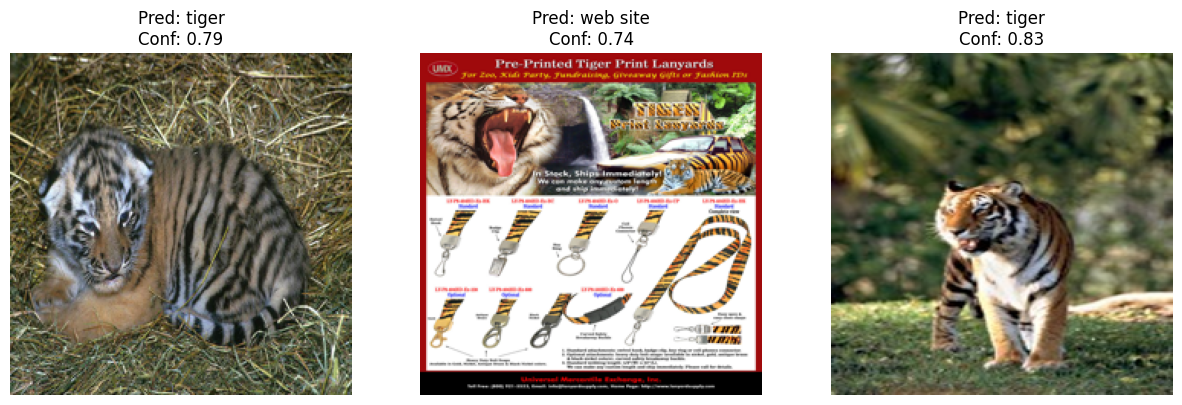

Images from striped folder with predictions:


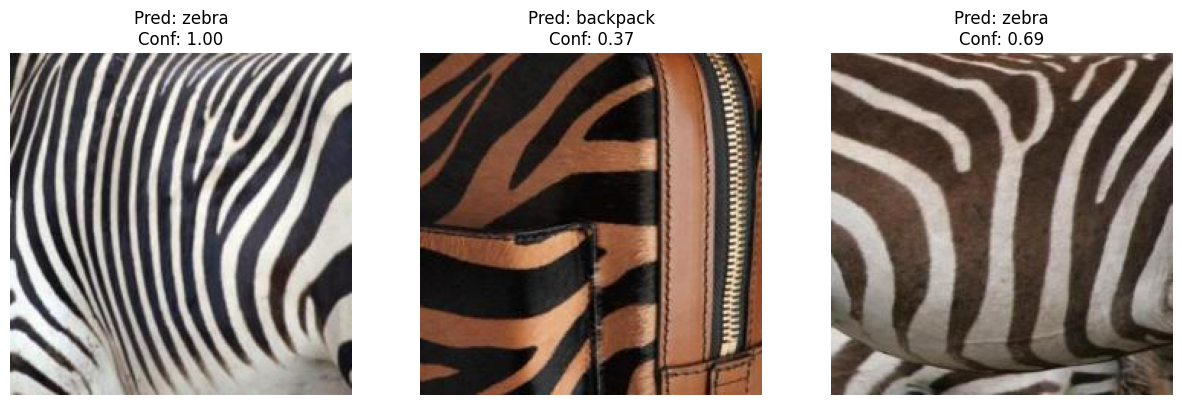

Images from random folder with predictions:


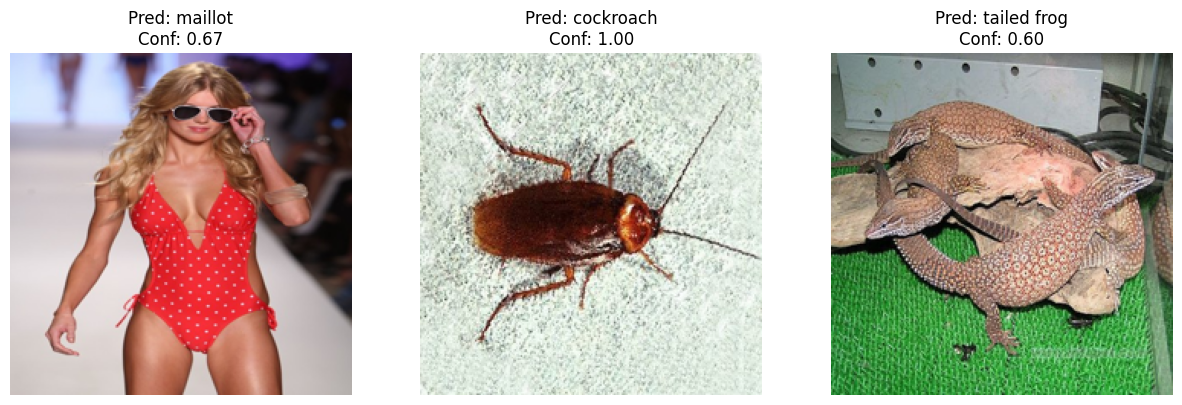

In [43]:
import matplotlib.pyplot as plt
import random
from PIL import Image
import numpy as np
import os

def load_labels(label_path):
    with open(label_path, 'r') as f:
        labels = f.read().splitlines()
    return labels

def display_random_images_with_predictions(directory, num_images, model_wrapper, labels, target_size=(224, 224)):
    # Get list of files in the directory
    files = os.listdir(directory)

    # Filter out image files (ending with .jpg)
    image_files = [f for f in files if f.endswith('.jpg')]

    # Check if there are enough image files
    if len(image_files) < num_images:
        print(f"Not enough images in {directory}.")
        return

    # Select random images
    random_images = random.sample(image_files, num_images)

    # Display selected images and predict their labels
    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))
    for i, image_file in enumerate(random_images):
        image_path = os.path.join(directory, image_file)
        image = Image.open(image_path).resize(target_size)

        # Convert image to model input format
        img_array = np.array(image) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Use model_wrapper's method to get predictions
        predictions = model_wrapper.get_predictions(img_array)
        predicted_class_index = np.argmax(predictions)  # Get predicted class index
        confidence_score = np.max(predictions)  # Get confidence score of the prediction
        predicted_class_name = labels[predicted_class_index]  # Get corresponding class name

        # Display image
        axs[i].imshow(image)
        axs[i].axis('off')
        axs[i].set_title(f"Pred: {predicted_class_name}\nConf: {confidence_score:.2f}")

    plt.show()

# Load labels
labels = load_labels(LABEL_PATH)

# Display images and predictions from target folder
source_dir = '/content/tcav/tcav/tcav_examples/image_models/imagenet/Minjie'
target = 'tiger'
concepts = ['striped']
random_folder = 'random500_10'

print("Images from target folder with predictions:")
display_random_images_with_predictions(os.path.join(source_dir, target), 3, model_wrapper=mymodel, labels=labels)

# Display 3 images from each concept folder with predictions
for concept in concepts:
    print(f"Images from {concept} folder with predictions:")
    display_random_images_with_predictions(os.path.join(source_dir, concept), 3, model_wrapper=mymodel, labels=labels)

# Display 3 images from a random folder with predictions
print("Images from random folder with predictions:")
display_random_images_with_predictions(os.path.join(source_dir, random_folder), 3, model_wrapper=mymodel, labels=labels)


Displaying images with predictions:

1. **Model Validation**: It provides a quick way to verify the model's accuracy and confidence on different image classes, helping assess its reliability.

2. **Concept Analysis**: It allows us to see if the model correctly associates specific concepts.

3. **Error Detection**: Visualizing confidence scores helps identify where the model might be overconfident or uncertain, guiding further improvements.


## Return Avtivations

In [44]:
act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir, activation_dir, max_examples=100)

## Run TCAV and show results

In [45]:
absl.logging.set_verbosity(0)
num_random_exp=15 # Recommend >10
mytcav = tcav.TCAV(sess,target,
                   concepts,
                   bottlenecks,
                   act_generator,
                   alphas,
                   cav_dir=cav_dir,
                   num_random_exp=num_random_exp) #15)
print ('Started')
results = mytcav.run(run_parallel=False)
print ('Completed')

Started
Completed


# Statistical Part

## Hypothesis:
H0: The 'striped' concent does not influence the prediction of target 'tiger' in the GoogleNet model.



H1: The 'striped' concent  influences the prediction of target 'tiger' in the GoogleNet model.

Class = tiger
  Concept = striped
    Bottleneck = mixed4c. TCAV Score = 0.68 (+- 0.19), random was 0.50 (+- 0.24). p-val = 0.005 (significant)
{'mixed4c': {'bn_vals': [0.6833333333333333], 'bn_stds': [0.18745369798669986], 'significant': [True]}}


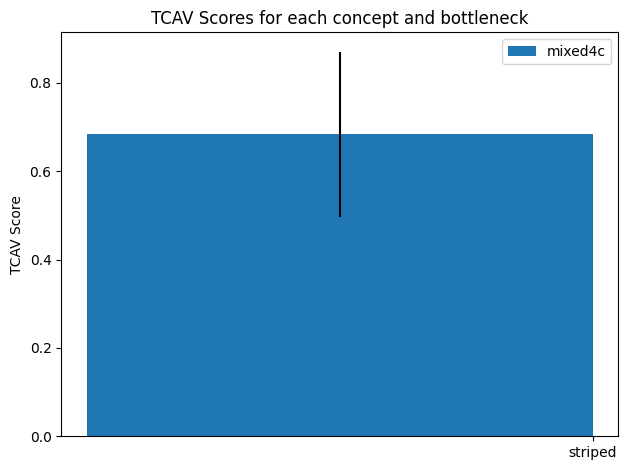

In [46]:
utils_plot.plot_results(results, num_random_exp=num_random_exp)

### Result Analysis

The TCAV score was **0.68**, while the score for random concepts was **0.50**. This high TCAV score indicates that the model strongly associates the "striped" pattern with the "tiger" class, suggesting that "striped" features are critical for the model in identifying images of tigers.

- **Significance Test**: With a p-value of **0.005**, which is well below the 0.05 significance threshold, the score difference between the "striped" concept and random concepts is statistically significant. This suggests that the model's activation on the "striped" concept for "tiger" is unlikely to be due to chance, reinforcing the importance of the "striped" feature in model decisions.


# Explanation Part
## CAV：
Concept Activation Vectors (CAVs) are a method used in interpretable machine learning to quantify how much a neural network relies on human-understandable concepts for making predictions. CAVs work by defining a direction in the network's internal activation space that corresponds to a particular concept, such as "striped". This direction is learned by training a linear classifier to distinguish between activations caused by images that contain the concept and those that do not. Once the CAV is computed, it can be used to assess how sensitive the model's predictions are to changes in the direction of that concept. The directional derivative along the CAV indicates whether the concept has a positive or negative influence on the model's output for a given class. CAVs enable insights into what the model has learned in terms of interpretable concepts.

## Implementation
For any given concept, TCAV measures the extent of that concept’s influence on the model’s prediction for a certain class

Concept Activation Vectors (CAV) are a numerical representation of a concept in the activation space of a neural network layer

Implementation:

1. Curate two datasets

  A concept dataset that represents concept C

  A random dataset
2. Target a hidden layer 𝑙 and train a binary classifier which separates the activations generated by the concept set from those generated by the random set

  The binary classifier can be an SVM or logistic regression model

  The coefficient vector of this trained binary classifier is the CAV, vlc

3. Given an image input 𝑥, we can measure its conceptual sensitivity by calculating the directional derivative of the prediction in the direction of the unit CAV


### Interesting Findings

- **Model Reliance on the "Striped" Concept**: The significance test highlights that the model heavily relies on the "striped" feature when identifying the "tiger" class. Interestingly, even without being explicitly told that "tigers" have stripes, the model has learned to associate "striped" patterns as a key feature for recognizing tigers. This provides insight into the model's internal preferences, making it more interpretable in the context of animal image classification.

- **Feature Extraction in the Bottleneck Layer**: The stable activation of "striped" patterns in the `mixed4c` bottleneck layer suggests that this layer is particularly sensitive to textures like stripes. This insight can guide the design of more interpretable model structures.